<a href="https://colab.research.google.com/github/FrancescoConti/efcl_ss_fir_genstim/blob/main/EFCL_SS_2024_FIR_Gen_Stimuli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

First, we import necessary & useful libraries.

In [ ]:
import numpy as np
from numpy import cos, sin, pi, absolute, arange
import math
import struct

import scipy.signal
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show

Define a couple of useful functions that we will use at the end of this notebook, mainly to write down our results in terms of stimuli:
- explicit two's complement representation
- base-16 representation of a generic numpy array
- simple function to fill a C header file with the contents of a numpy array


In [ ]:
def twos_complement(
    x,
    width = 16
):
    y = np.array(x)
    y[x<0] = 2**(width) + y[x<0]
    return y

def hex_repr(
    x,
    width = 16
):
    if width == 16:
        padding = 4 if x == 0 else \
                  3 if np.bitwise_and(x, 0xfff0) == 0 else \
                  2 if np.bitwise_and(x, 0xff00) == 0 else \
                  1 if np.bitwise_and(x, 0xf000) == 0 else 0
    elif width == 32:
        padding = 8 if x == 0 else \
                  7 if np.bitwise_and(x, 0xfffffff0) == 0 else \
                  6 if np.bitwise_and(x, 0xffffff00) == 0 else \
                  5 if np.bitwise_and(x, 0xfffff000) == 0 else \
                  4 if np.bitwise_and(x, 0xffff0000) == 0 else \
                  3 if np.bitwise_and(x, 0xfff00000) == 0 else \
                  2 if np.bitwise_and(x, 0xff000000) == 0 else \
                  1 if np.bitwise_and(x, 0xf0000000) == 0 else 0
    return np.base_repr(x, base=16, padding=padding)

# Function to write Stimuli
def stimuli_tensor2string(
    x,
    width = 16,
    line_prefix = "",
    line_postfix = ""
):
    s = ""
    x = twos_complement(x, width=width)
    for el in x.flatten():
        s += """%s%s%s\n""" % (line_prefix, hex_repr(el, width=width), line_postfix)
    return s.lower()

## Filter Parameter Section

Our baseline FIR filter will work on a sample signal with 512 samples at a sampling rate of 100 Hz (of course, the units are fully arbitrary in this example). Specifically, we design a filter with a passband frequency of 8 Hz and a cutoff frequency of 12 Hz.

In [ ]:
# Parameters
samples = 512
sample_rate = 100
nyquist_rate = sample_rate/2

passband = 8
cutoff = 12

We use the *scipy* function `firwin` to implement a FIR filter with 50 taps using a Blackman window.

In [ ]:
# Filter Design
# Use firwin to create a lowpass FIR filter with Hamming window.

# N is the number of Taps
N = 50
taps = np.zeros(N, np.float32)
taps = scipy.signal.firwin(N, cutoff/nyquist_rate, window=('blackman')) #Window can change, check documentation

## Plot your Filter frequency and step response

We verify that the designed FIR filter complies with our initial constraints by plotting the filter taps and the frequency response.

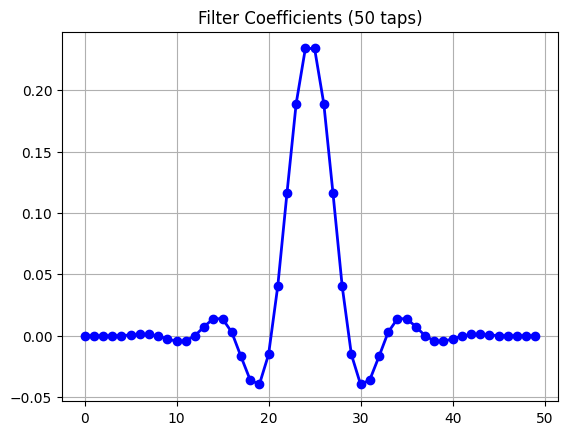

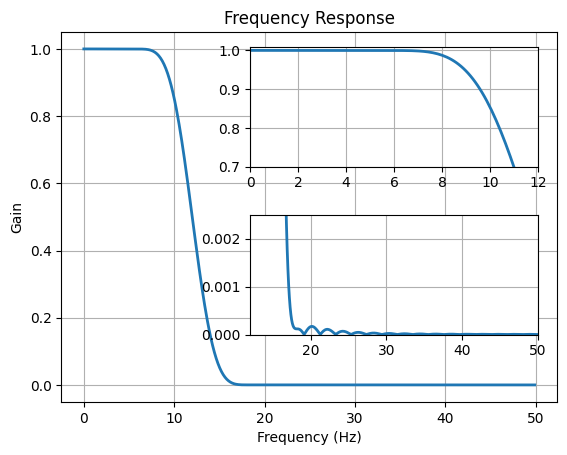

In [ ]:
figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

figure(2)
clf()
w, h = scipy.signal.freqz(taps, worN=512)
plot((w/pi)*nyquist_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

### Zoom in section ####
zoom_in = cutoff
#zoom_in = passband
# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyquist_rate, absolute(h), linewidth=2)
xlim(0,zoom_in)
ylim(0.7, 1.01)
#ylim(0.7, 1.01)
grid(True)

zoom_in = cutoff
# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyquist_rate, absolute(h), linewidth=2)
xlim(zoom_in, nyquist_rate)
ylim(0.0, 0.0025)
grid(True)
show()

## Reference Signal

As a target signal to filter, we use a very simple periodic signal composing multiple sinusoids at several frequencies and phase shifts. We plot both the reference signal across time and its FFT, showing peaks at the various sinusoid frequencies.

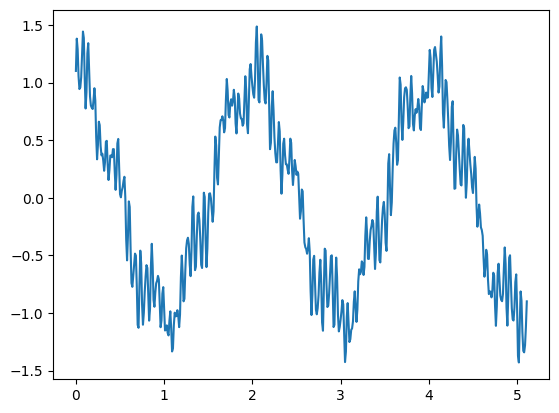

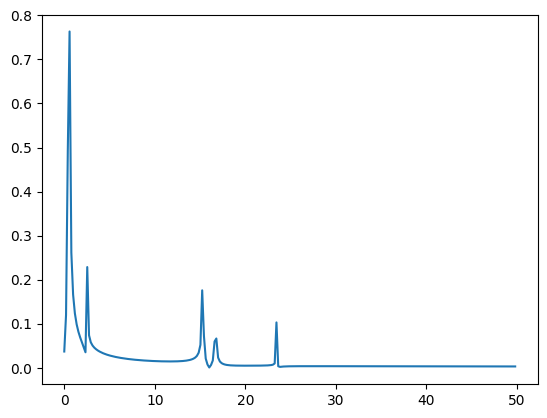

In [ ]:
# Reference Signal
t = arange(samples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)

figure(3)
plot(t, x)

yf = scipy.fft.fft(x)
xf = scipy.fft.fftfreq(samples, 1.0/sample_rate)[:samples//2]
figure(4)
plot(xf, 2.0/samples * np.abs(yf[0:samples//2]))
show()

The FIR filter should filter out all harmonics except for the first two: let us verify it works this way by plotting the filtered output and the FFT.

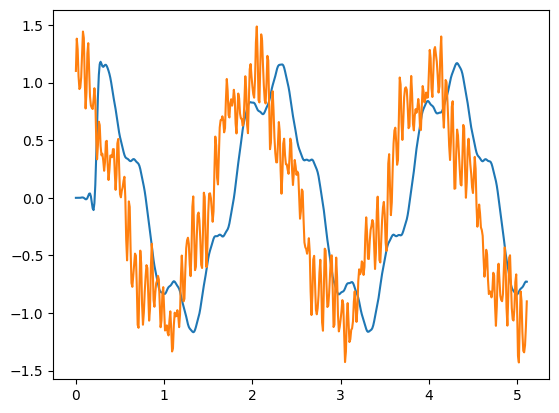

In [ ]:
ygold = scipy.signal.lfilter(taps, np.asarray((1,)), x)
plot(t,ygold)
plot(t,x)
show()

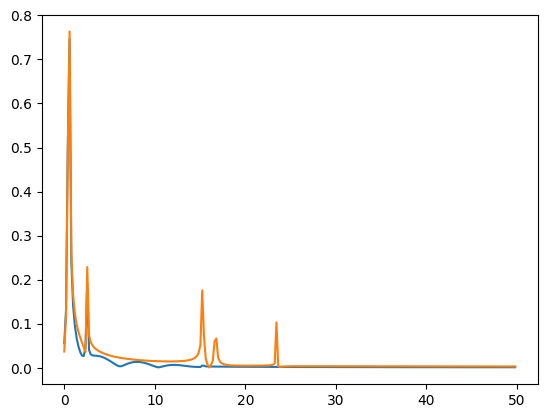

In [ ]:
x_freq = scipy.fft.fft(x)
y_freq = scipy.fft.fft(ygold)
freq = scipy.fft.fftfreq(samples, 1.0/sample_rate)[:samples//2]
plot(freq, 2.0/samples * np.abs(y_freq[0:samples//2]))
# show()
plot(freq, 2.0/samples * np.abs(x_freq[0:samples//2]))
show()

## Generate Header

## Fixed point conversion

To deploy the FFT to hardware, we need to convert it to a fixed-point representation. We do that by deriving the adequate representation considering a certain number of bits `NB_BITS` to represent correctly all the dynamic (the absolute maximum value of the signal/taps) while being as precise as possible on the least significant bits.
We constrain `NB_BITS=14` to leave a bit of wiggle room for intermediate results and partial sums, as we will employ a 32-bit accumulator in some of our FIR implementations on PULPissimo.

In [ ]:
# Find the max (coefficients and inputs)

# Convert the Taps and Inputs to the Selected Fixed point format. Use the same names for the variables

NB_BITS = 14
x_abs_max = np.abs(x).max()
x_sign_bit  = 1
x_int_bits  = int(np.ceil(np.log2(x_abs_max)))
x_frac_bits = NB_BITS - x_sign_bit - x_int_bits

h_abs_max = np.abs(taps).max()
h_sign_bit  = 1
h_int_bits  = int(np.ceil(np.log2(h_abs_max)))
h_frac_bits = NB_BITS - h_sign_bit - h_int_bits
print("X representation: Q%d.%d" % (x_int_bits, x_frac_bits))
print("H representation: Q%d.%d" % (h_int_bits, h_frac_bits))

X representation: Q1.12
H representation: Q-2.15


Once derived the correct representation for data, we convert signals and taps to fixed-point representation using scaling, rounding and saturation (which should be unused by design if we do not tamper the data representation!)

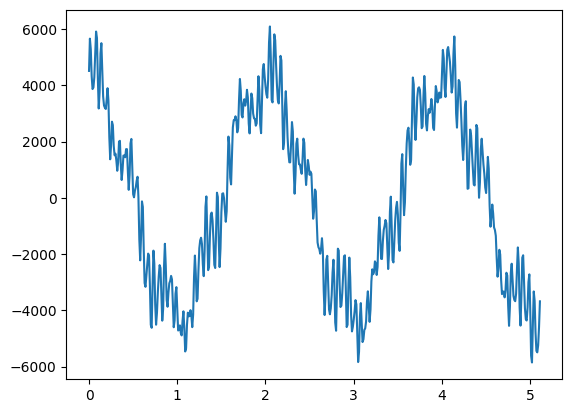

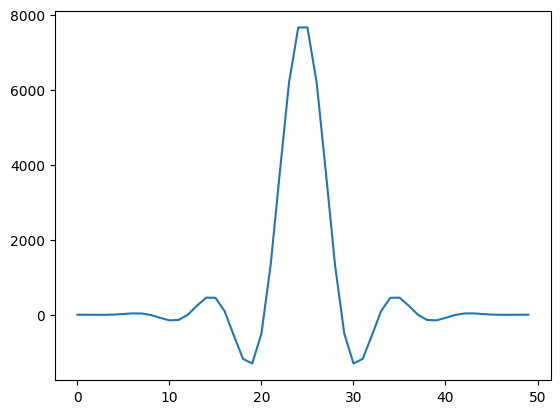

In [ ]:
# Convert to Fixed Point
x_scaled = x / 2**(-x_frac_bits)
x_rounded = np.int64(np.round(x_scaled))
x_sat = np.clip(x_rounded, -2**(x_int_bits+x_frac_bits), 2**(x_int_bits+x_frac_bits)-1)

h_scaled = taps / 2**(-h_frac_bits)
h_rounded = np.int64(np.round(h_scaled))
h_sat = np.clip(h_rounded, -2**(h_int_bits+h_frac_bits), 2**(h_int_bits+h_frac_bits)-1)

# taps_scaled = # scale the taps
# taps_rounded = taps_scaled.astype(int)

figure(5)
plot(t, x_sat)
show()
plot(h_sat)

We test if this work correctly by comparing the fixed-point output with the original one: they are coincident (at least for `NB_BITS=14`).

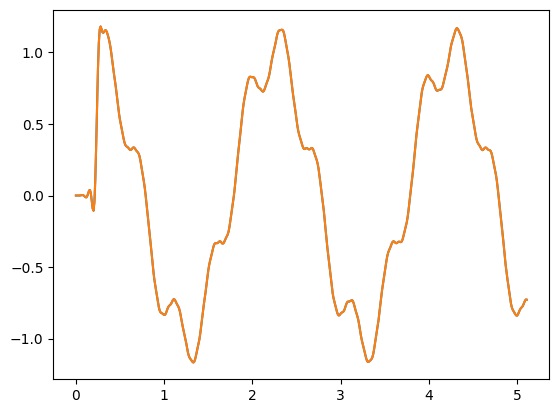

In [ ]:
y_scaled_doublebits = np.int64(np.round(scipy.signal.lfilter(np.float32(h_sat), np.asarray((1,)), np.float32(x_sat))))
y_scaled = np.right_shift(y_scaled_doublebits, h_frac_bits)
y_sat    = np.clip(y_scaled, -2**(x_int_bits+x_frac_bits), 2**(x_int_bits+x_frac_bits)-1)
ygold_fixed = y_sat * 2**(-x_frac_bits)
plot(t,ygold_fixed)
plot(t,ygold)

## Generate the Stimuli

We write down stimuli files that will be used for PULPissimo (`x_stim32.h`, `h_stim32.h` and `y_gold32.h`) and for the standalone FIR HWPE testbench (`x_stim.txt`, `h_stim.txt`, `y_gold.txt`).

In [ ]:
# standalone testbench stimuli
with open("x_stim.txt", "w") as f:
    f.write(stimuli_tensor2string(x_sat, width=16))
with open("h_stim.txt", "w") as f:
    f.write(stimuli_tensor2string(h_sat, width=16))
with open("y_gold.txt", "w") as f:
    f.write(stimuli_tensor2string(y_sat, width=16))

In [ ]:
def write_header(vec, filename, vector_name, attribute=""):
    vec_plus = np.array(vec)
    vec_plus[vec_plus < 0] = 65536 + vec_plus[vec_plus<0]
    with open(filename, "w") as f:
        f.write("#include <stdint.h>\n\n")
        f.write("%suint32_t %s[] = {\n" % (attribute, vector_name))
        f.write(stimuli_tensor2string(np.bitwise_or(vec_plus.reshape(-1,2)[:,0], vec_plus.reshape(-1,2)[:,1] << 16), width=32, line_prefix="  0x", line_postfix=","))
        f.write("  0x0 // padding\n};\n\n")

write_header(x_sat, "x_stim32.h", "x_stim", "__attribute__((aligned(16))) ")
write_header(h_sat, "h_stim32.h", "h_stim", "__attribute__((aligned(16))) ")
write_header(y_sat, "y_gold32.h", "y_gold", "__attribute__((aligned(16))) ")
